In [172]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

# Experimental information

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**
*  anti-His tag spots: All of the recombinant proteins that are used to coat the plates have hexa-His tags cloned into them, and the coat protein in these spots is anti-His. In this experiment, all of the recombinant antigens were spotted here on the anti-His coated spot, then serum was added so that the spot is representative of a polyclonal response. There was more cross-reactivity than expected and **this control will not be used in the future covid plates.**

# Data format conventions

For ease of reading and manipulating data, all data is converted in $n$-dimensional arrays. 
* Well metadata is #wells $\times$ 4 array. 
* antigen metadata is  #rows $\times$ #columns in the array.
* background corrected ODs is a 4D float array (Well row x Well column x Array row x Array column).

# Read identity of wells and antigen spots in 2D arrays

In [9]:
plateinfo_path=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera/PlateInfo.csv'
antigenOD_path=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera/20200327_analyzedPlate/ODs_2020_328_1030.xlsx'

In [35]:
plateinfo_dataframe=pd.read_csv(plateinfo_path)
pprint(plateinfo_dataframe)
plateInfo=plateinfo_dataframe.to_numpy()
pprint(plateInfo)

   Well     Sera ID              Type  Dilution
0    A1     Mouse 1        Diagnostic      1:50
1    A2     Mouse 1        Diagnostic      1:50
2    A3     Mouse 2        Diagnostic      1:50
3    A4     Mouse 2        Diagnostic      1:50
4    A5     Mouse 3        Diagnostic      1:50
..  ...         ...               ...       ...
91   H8  MAb-biotin  control/standard   0.41 nM
92   H9  MAb-biotin  control/standard  0.136 nM
93  H10  MAb-biotin  control/standard  0.045 nM
94  H11  MAb-biotin  control/standard  0.015 nM
95  H12         NaN               NaN       NaN

[96 rows x 4 columns]
array([['A1', 'Mouse 1', 'Diagnostic', '1:50'],
       ['A2', 'Mouse 1', 'Diagnostic', '1:50'],
       ['A3', 'Mouse 2', 'Diagnostic', '1:50'],
       ['A4', 'Mouse 2', 'Diagnostic', '1:50'],
       ['A5', 'Mouse 3', 'Diagnostic', '1:50'],
       ['A6', 'Mouse 3', 'Diagnostic', '1:50'],
       ['A7', 'Mouse 4', 'Diagnostic', '1:50'],
       ['A8', 'Mouse 4', 'Diagnostic', '1:50'],
       ['A9', 'Mo

In [11]:
converter = {col: str for col in range(0,7)}
antigens_dataframe=pd.read_excel(antigenOD_path, sheet_name='antigens', converters=converter)
antigens=antigens_dataframe.to_numpy()[:,1:] 
pprint(antigens)

array([['xkappa-biotin', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7',
        'xkappa-biotin'],
       ['xkappa-biotin', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7',
        'xmouse-IgG'],
       ['anti-HIS tag', '15731', '15742', '15750', '15878', '15946',
        '15960', 'Q411'],
       ['anti-HIS tag', '15731', '15742', '15750', '15878', '15946',
        '15960', 'Q411'],
       ['anti-HIS tag', '15974', '16061', 'FVM04', 'VIC122', 'Q206',
        'Q314', 'GFP-foldon'],
       ['xkappa-biotin', '15974', '16061', 'FVM04', 'VIC122', 'Q206',
        'Q314', 'xkappa-biotin']], dtype=object)


# Read ODs of all wells in a 4D array (Well row x Well column x Array row x Array column)

## Read data

In [12]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,8)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [13]:
# Read all wells into dictionary and into a 4D numpy array.
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        antigenOD_dataframe=pd.read_excel(antigenOD_path, sheet_name=well_key)
        antigenOD[r,c,:,:]=antigenOD_dataframe.to_numpy()[:,1:] # First column is simply the index. to_numpy returns 6x9 array.
        wellID[r,c] = well_key

## how to index the OD data.

#### direct indexing

In [14]:
pprint(antigenOD[0,0]) # Well A1

array([[1.48690358, 2.29510727, 1.88054858, 2.58605292, 1.28097541,
        2.65749052, 1.4895249 , 1.55835905],
       [1.46043415, 1.85433613, 2.27518306, 2.74934729, 1.43469453,
        2.05008816, 1.69365441, 3.02854479],
       [3.58943717, 1.60508459, 2.58859898, 1.26907949, 5.79775172,
        1.27786073, 1.82586891, 1.66100972],
       [3.3421515 , 1.81320625, 2.73909223, 1.27429019, 2.60367051,
        1.25637504, 2.31202412, 1.60264153],
       [3.43131823, 2.24281023, 3.27112586, 2.11036309, 2.43932369,
        2.12406351, 1.55815716, 4.61593211],
       [1.46372823, 2.1719292 , 3.20397848, 2.05375365, 2.36963313,
        2.01548414, 1.32053514, 1.4020999 ]])


In [15]:
pprint(antigenOD[0,3]) # well A4

array([[1.43988273, 1.3451414 , 2.99774562, 1.21434209, 1.29873839,
        1.08886344, 1.23414691, 1.61283121],
       [1.44550936, 1.15400541, 2.96651674, 1.26165007, 1.09079668,
        1.081295  , 1.06818851, 3.55750328],
       [1.87884234, 1.28353302, 1.11147366, 1.20569399, 1.07842211,
        1.03519571, 1.13637536, 1.10705243],
       [1.93024336, 1.06879314, 1.16157532, 1.11076694, 1.08172383,
        1.04190418, 1.11740187, 1.08562124],
       [1.74705778, 1.05420597, 1.3725761 , 1.11878548, 1.1752757 ,
        1.0787549 , 1.05155942, 1.00879728],
       [1.44784659, 1.06575727, 1.30663138, 1.23790682, 1.07855464,
        1.06769399, 1.05361099, 1.40577401]])


#### logical indexing

In [16]:
pprint(antigenOD[wellID == 'A4'])

array([[[1.43988273, 1.3451414 , 2.99774562, 1.21434209, 1.29873839,
         1.08886344, 1.23414691, 1.61283121],
        [1.44550936, 1.15400541, 2.96651674, 1.26165007, 1.09079668,
         1.081295  , 1.06818851, 3.55750328],
        [1.87884234, 1.28353302, 1.11147366, 1.20569399, 1.07842211,
         1.03519571, 1.13637536, 1.10705243],
        [1.93024336, 1.06879314, 1.16157532, 1.11076694, 1.08172383,
         1.04190418, 1.11740187, 1.08562124],
        [1.74705778, 1.05420597, 1.3725761 , 1.11878548, 1.1752757 ,
         1.0787549 , 1.05155942, 1.00879728],
        [1.44784659, 1.06575727, 1.30663138, 1.23790682, 1.07855464,
         1.06769399, 1.05361099, 1.40577401]]])


In [17]:
pprint(antigenOD[wellID == 'A1'])

array([[[1.48690358, 2.29510727, 1.88054858, 2.58605292, 1.28097541,
         2.65749052, 1.4895249 , 1.55835905],
        [1.46043415, 1.85433613, 2.27518306, 2.74934729, 1.43469453,
         2.05008816, 1.69365441, 3.02854479],
        [3.58943717, 1.60508459, 2.58859898, 1.26907949, 5.79775172,
         1.27786073, 1.82586891, 1.66100972],
        [3.3421515 , 1.81320625, 2.73909223, 1.27429019, 2.60367051,
         1.25637504, 2.31202412, 1.60264153],
        [3.43131823, 2.24281023, 3.27112586, 2.11036309, 2.43932369,
         2.12406351, 1.55815716, 4.61593211],
        [1.46372823, 2.1719292 , 3.20397848, 2.05375365, 2.36963313,
         2.01548414, 1.32053514, 1.4020999 ]]])


# Plot standard curve.

In [142]:
# Prepare arrays for logical indexing.
# Logical indexing works only for numpy array only not the standard python lists.

wellIdx = np.array([row+str(col) for row in ['A','B','C','D','E','F','G','H'] for col in range(1,13)])
wellmetaIdx=np.array(['Well','SeraID','Type','Concentration'])
antigenIdx = antigens.flatten()

# Transform antigenODs to wellxspot structure.
ODwellbyantigen=antigenOD.reshape(len(wellIdx),len(antigenIdx))
pprint(wellIdx)
pprint(antigenIdx)

array(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10',
       'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7',
       'D8', 'D9', 'D10', 'D11', 'D12', 'E1', 'E2', 'E3', 'E4', 'E5',
       'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F1', 'F2', 'F3',
       'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G1',
       'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11',
       'G12', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10',
       'H11', 'H12'], dtype='<U3')
array(['xkappa-biotin', '114', '100', 'KZ52', 'c13C6', 'c2G4', 'c4G7',
       'xkappa-biotin', 'xkappa-biotin', '114', '100', 'KZ52', 'c13C6',
       'c2G4', 'c4G7', 'xmouse-IgG', 'anti-HIS tag', '15731', '15742',
       '15750', '15878', '15946', '15960', 'Q411', 'anti-HIS tag',
       '15731', '15742', '15750', '

## Find concentrations in control wells

In [133]:
controlWells=np.array(['H'+str(col) for col in range(2,12)])
controlConcentrations= np.concatenate([plateInfo[allWells == well,wellmetaIdx == 'Concentration'] for well in controlWells])
pprint(controlConcentrations)

array(['300 nM', '100 nM', '33.3 nM', '11.1 nM', '3.7 nM', '1.23 nM',
       '0.41 nM', '0.136 nM', '0.045 nM', '0.015 nM'], dtype=object)


In [134]:
concentrations=np.concatenate([np.fromstring(strconc, dtype=np.float32, sep=' ') for strconc in controlConcentrations])

/Users/shalin.mehta/miniconda3/envs/serocovid/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'mAb-biotin (nM)')

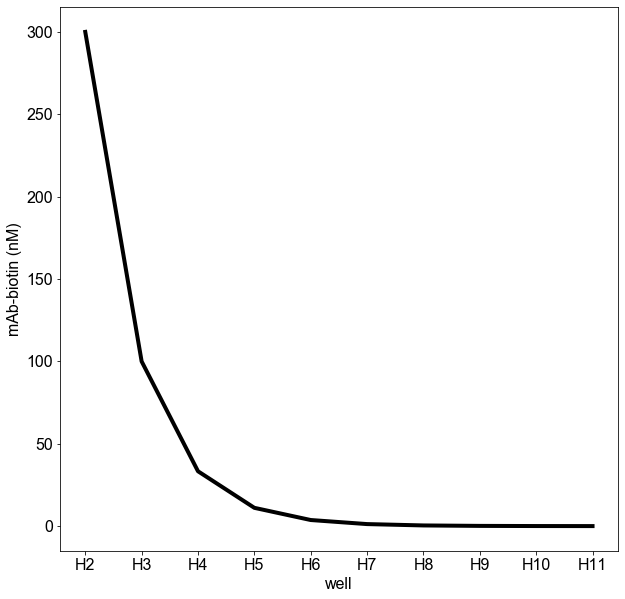

In [182]:
plt.figure(figsize=(10,10))
plt.plot(concentrations, lw=4, c='k')
plt.xticks(ticks=np.arange(len(concentrations)),labels=controlWells); plt.xlabel('well'); plt.ylabel('mAb-biotin (nM)')

## OD of xkappa-biotin should not change with concentration.

In [183]:
# Extract ODs across control wells and over all spots.
xkappaOD=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'xkappa-biotin'] for well in controlWells])
xkappaODMean=np.mean(xkappaOD, axis =1)

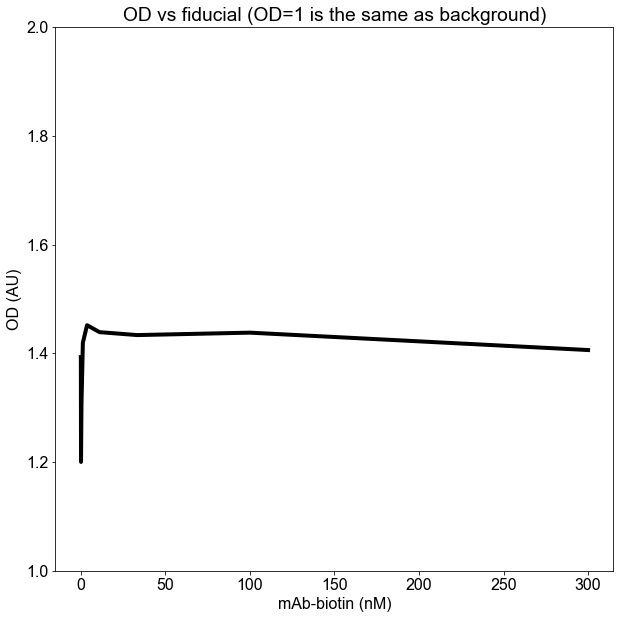

In [187]:
plt.figure(figsize=(10,10))
plt.plot(concentrations, xkappaODMean, lw=4, c='k')
plt.ylim([1,2])
plt.xlabel('mAb-biotin (nM)')
plt.ylabel('OD (AU)')
plt.title('OD vs fiducial (OD=1 is the same as background)');

In [ ]:
## OD of GFP-foldon (-ve control) should be lower than fiducial and OD of xmouse-IgG (+ve control) should be higher than 